In [14]:
import cv2
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import csv
import matplotlib.pyplot as plt
import itertools

In [2]:
def load_frames(vid_path):
    frames = []
    
    imgs = os.listdir(vid_path)
    for img in imgs:
        img_path = os.path.join(vid_path, img)
        frame = cv2.imread(img_path)
        frame = cv2.resize(frame, (160, 90))

        # cv2.imshow("frame", frame)
        # cv2.waitKey(33)

        frames.append(frame)

    return frames


def extract_optical_flow(frames):
    features = []

    # 初始化前一帧
    prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

    for frame in frames[1:]:
        # 將當前帧轉換為灰度圖
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 計算光流
        flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # 將光流的水平和垂直分量組合為特徵向量
        flow_feature = flow.reshape(-1)
        features.append(flow_feature)

        # 更新前一帧
        prev_frame = gray

    return np.array(features)


def preprocess(path):
    features = []
    vids = os.listdir(path)
    for vid in vids:
        vid_path = os.path.join(path, vid)
        frames = load_frames(vid_path)
        optical_flow_features = extract_optical_flow(frames)
        # print(optical_flow_features.shape)
        features.append(optical_flow_features)

    return np.array(features)


def load_label(csv_path):
    labels = []
    with open(csv_path, 'r') as file:
        rows = csv.reader(file)
        for row in rows:
            labels.append(row[2])

    return np.array(labels)

In [3]:
X_train = preprocess('./train')
print(X_train.shape)
X_test = preprocess('./val')
print(X_test.shape)

y_train = load_label('./train.csv')
print(y_train.shape)
y_test = load_label('./val.csv')
print(y_test.shape)

(82, 29, 28800)
(24, 29, 28800)
(82,)
(24,)


In [4]:
# 將三維特徵數組轉換為二維
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# 创建 SVM 模型
svm_model = SVC()

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train_flat, y_train)

# 打印最佳参数和最佳分数
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Score: 0.46470588235294114


In [6]:
# 將三維特徵數組轉換為二維
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

svm_model = SVC(kernel='linear', C=0.1)

# 訓練SVM模型
svm_model.fit(X_train_flat, y_train)

# 在測試集上進行預測
y_pred = svm_model.predict(X_test_flat)

# 計算準確率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.20833333333333334


In [10]:
cnf_matrix_sklearn = confusion_matrix(y_test, y_pred)
print(cnf_matrix_sklearn)

[[0 3 0 0 1 0]
 [0 5 0 0 0 0]
 [0 4 0 0 0 0]
 [0 3 0 0 0 0]
 [1 3 0 0 0 0]
 [0 4 0 0 0 0]]


In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[0 3 0 0 1 0]
 [0 5 0 0 0 0]
 [0 4 0 0 0 0]
 [0 3 0 0 0 0]
 [1 3 0 0 0 0]
 [0 4 0 0 0 0]]


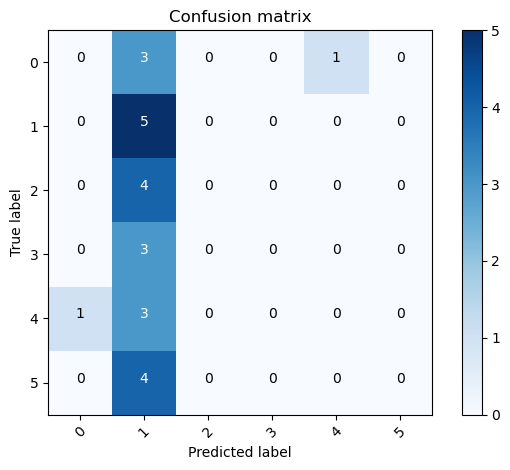

In [16]:
plot_confusion_matrix(cnf_matrix_sklearn, [0, 1, 2, 3, 4, 5], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)